## Линейная регрессия

<b>В рамках данной работы будут затронуты и выполнены следующие задачи:</b>
    
    1) Предобработка данных;
    2) Построение диаграмм рассеяния и матрицы корреляций;
    3) Преобразование категориальных переменных;
    4) Построение объясняющей модели и отбор признаков;
    5) Построение предсказательной модели и отбор признаков;
    6) Усовершенствование предсказательной модели
    

---

В этом задании нам предстоит проанализировать набор данных [Weather in Szeged 2006-2016](https://www.kaggle.com/budincsevity/szeged-weather), содержащий информацию о погоде. В качестве зависимой переменной возьмём температуру воздуха в градусах Цельсия (`Temperature (C)`).

Наша цель состоит в том, чтобы построить две линейные регрессионные модели: объясняющую и предиктивную. Объясняющая модель должна быть пригодна для статистической интерпретации зависимостей, то есть показывать, какие факторы влияют на температуру воздуха, каким образом и какое возможное объяснение этого влияния можно привести. Предиктивная модель может быть совершенно ужасной с точки зрения статистики (например, все коэффициенты могут быть не значимы), но она должна давать хорошие прогнозы в соответствии с некоторой метрикой.

Хотя приведённые данные имеют формат временных рядов, мы будем игнорировать это и рассматривать их как обычные кросс-секционные данные (то есть как независимые наблюдения в пространстве).

### Предобработка данных 

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
plt.style.use('ggplot')
sns.set_style('darkgrid')



Загрузим данные из файла `weatherHistory.csv`.

In [2]:

wh = pd.read_csv('weatherHistory.csv')
wh.head(5)



,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


---

Следует изучить статью о том, что такое [apparent temperature](https://www.kxan.com/weather/difference-between-temperature-and-feels-like-temperature/) (также называемая "feels-like temperature" и "heat index").



In [3]:

wh[['Temperature (C)', 'Apparent Temperature (C)']].corr()
#Corr = 0.996 => Очень сильная линейная связь => возникнет мультиколлинеарность.


,Temperature (C),Apparent Temperature (C)
Temperature (C),1.000000,0.992629
Apparent Temperature (C),0.992629,1.000000



Целевая переменная (по заданию) - Temperature (C).
 
Дело в том, что "Apparent Temperature (C)" это та же температура (Temperature (C)), но с учетом скорости ветра (Wind Speed (km/h)) и влажности (Humidity). Получается, что "Apparent Temperature (C)" не может быть регрессором для предсказывания "Temperature (C)", тк <b>Apparent temperature является линейной комбинацией обычной 'Temperature'.</b> Об этом также свидетельтсвует найденная корреляция (почти единица).

Т.е. если мы будем использовать "Apparent Temperature (C)" в машинном обучении для предсказания обычной температуры, то возникнет ситуация мультиколлинеарности, машина будет учиться неправильно, скорее всего, это приведет к типичной "Переобучаемости модели".

Следовательно, удалим данный признак.


Также удалим следующие признаки:
- `Formatted Date` (потому что договорились, что не обращаем внимания на даты).
- `Daily Summary` (будем использовать просто `Summary`). 

In [4]:

wh = wh.drop(columns = ['Apparent Temperature (C)', 'Formatted Date', 'Daily Summary'], axis=1) 
wh


,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
0,Partly Cloudy,rain,9.472222,0.89,14.1197,251.0,15.8263,0.0,1015.13
1,Partly Cloudy,rain,9.355556,0.86,14.2646,259.0,15.8263,0.0,1015.63
2,Mostly Cloudy,rain,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94
3,Partly Cloudy,rain,8.288889,0.83,14.1036,269.0,15.8263,0.0,1016.41
4,Mostly Cloudy,rain,8.755556,0.83,11.0446,259.0,15.8263,0.0,1016.51
...,...,...,...,...,...,...,...,...,...
96448,Partly Cloudy,rain,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36
96449,Partly Cloudy,rain,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16
96450,Partly Cloudy,rain,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66
96451,Partly Cloudy,rain,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95


---

<b>Проверим данные на пропуски и дубликаты:</b>

In [5]:
wh.isnull().sum()

Summary                     0
Precip Type               517
Temperature (C)             0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
dtype: int64

In [6]:
wh.loc[wh['Precip Type'].isnull()].head()
#Сложно заменить пропуски по данной переменной, поэтому просто удалим эти 517 наблюдений

,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
52672,Mostly Cloudy,NaN,19.016667,0.26,14.8764,163.0,9.982,0.0,1002.40
52674,Mostly Cloudy,NaN,17.850000,0.28,13.7977,169.0,9.982,0.0,1001.79
52675,Mostly Cloudy,NaN,16.322222,0.32,10.8192,151.0,9.982,0.0,1001.60
52677,Mostly Cloudy,NaN,12.566667,0.43,9.0160,159.0,9.982,0.0,1001.92
52678,Mostly Cloudy,NaN,12.927778,0.47,17.6295,197.0,16.100,0.0,1002.20


In [7]:
wh = wh.dropna() #Пропусков больше нет.
wh.isnull().sum() #Проверка

Summary                   0
Precip Type               0
Temperature (C)           0
Humidity                  0
Wind Speed (km/h)         0
Wind Bearing (degrees)    0
Visibility (km)           0
Loud Cover                0
Pressure (millibars)      0
dtype: int64

In [8]:
#Что касается дубликатов?
wh.duplicated().sum()

72

In [9]:
#Удалим дубликаты:
wh = wh.drop_duplicates()
wh.duplicated().sum() #Проверка

0

---

In [10]:
wh.nunique()

Summary                     27
Precip Type                  2
Temperature (C)           7573
Humidity                    90
Wind Speed (km/h)         2484
Wind Bearing (degrees)     360
Visibility (km)            949
Loud Cover                   1
Pressure (millibars)      4971
dtype: int64

=> Признак 'Loud Cover' не несет никакой пользы для предсказательной модели, потому что всегда равняется только одному и тому же значению (нулю). Поэтому также удалим это значение:

In [11]:

wh = wh.drop(columns=['Loud Cover'], axis=1)
wh.head()


,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,Partly Cloudy,rain,9.472222,0.89,14.1197,251.0,15.8263,1015.13
1,Partly Cloudy,rain,9.355556,0.86,14.2646,259.0,15.8263,1015.63
2,Mostly Cloudy,rain,9.377778,0.89,3.9284,204.0,14.9569,1015.94
3,Partly Cloudy,rain,8.288889,0.83,14.1036,269.0,15.8263,1016.41
4,Mostly Cloudy,rain,8.755556,0.83,11.0446,259.0,15.8263,1016.51


---

<b>Построим диаграммы рассеяния для оставшихся признаков:</b>

In [12]:

wh.select_dtypes(include=['float64', 'int64']).columns.tolist() #Выделение всех числовых переменных для удобства


['Temperature (C)',
 'Humidity',
 'Wind Speed (km/h)',
 'Wind Bearing (degrees)',
 'Visibility (km)',
 'Pressure (millibars)']

<AxesSubplot:xlabel='Pressure (millibars)', ylabel='Temperature (C)'>

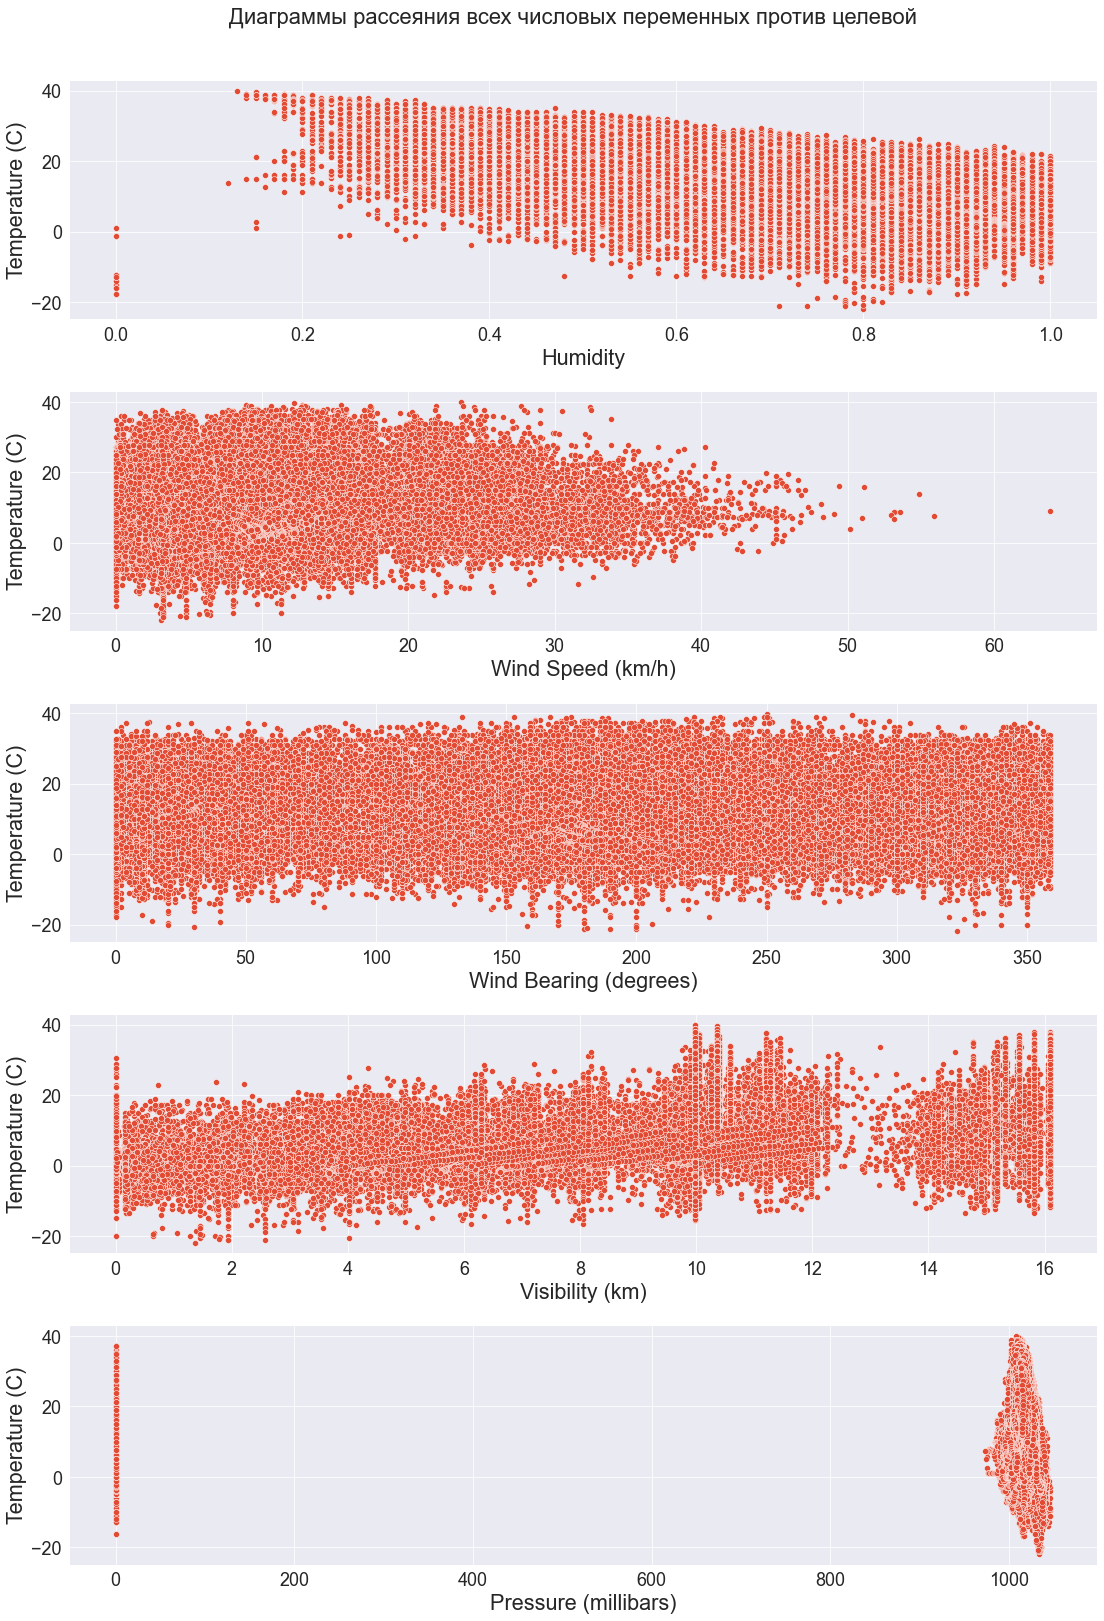

In [13]:


plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(5, 1, figsize = (16, 23))
fig.suptitle('Диаграммы рассеяния всех числовых переменных против целевой', fontsize=22)

fig.tight_layout(pad=2.2)    
plt.subplots_adjust(hspace=0.3)


sns.scatterplot(data=wh, x='Humidity', y='Temperature (C)', ax=ax[0])
sns.scatterplot(data=wh, x='Wind Speed (km/h)', y='Temperature (C)', ax=ax[1])
sns.scatterplot(data=wh, x='Wind Bearing (degrees)', y='Temperature (C)', ax=ax[2])    
sns.scatterplot(data=wh, x='Visibility (km)', y='Temperature (C)', ax=ax[3])   
sns.scatterplot(data=wh, x='Pressure (millibars)', y='Temperature (C)', ax=ax[4])




Отношение между переменными 'Temperature (C)' и 'Humidity' напоминает график отрицательной линейной связи.

Отношение между переменными 'Temperature (C)' и 'Visibility (km)' напоминает график положительной линейной связи.

Это значит что Humidity и Visibility могут быть удобными регрессорами для предсказания целевой переменной. Остальные три переменные будут точно иметь более слабое влияние в предсказательной модели.



---

<b>Преобразуем категориальные переменные при помощи One Hot Encoding (то есть в дамми-переменные):</b>

In [14]:

wh.select_dtypes(include=['object']).columns.tolist() #Выделение всех нечисловых переменных для удобства


['Summary', 'Precip Type']

In [15]:

summary_dum = pd.get_dummies(wh.Summary, prefix='Summary').iloc[:, 1:]
prec_dum = pd.get_dummies(wh['Precip Type'], prefix='Precip Type').iloc[:, 1:]

whh = pd.concat([wh, summary_dum, prec_dum], axis=1)
whh


,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Summary_Breezy and Dry,Summary_Breezy and Foggy,...,Summary_Overcast,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy,Precip Type_snow
0,Partly Cloudy,rain,9.472222,0.89,14.1197,251.0,15.8263,1015.13,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Partly Cloudy,rain,9.355556,0.86,14.2646,259.0,15.8263,1015.63,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Mostly Cloudy,rain,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Partly Cloudy,rain,8.288889,0.83,14.1036,269.0,15.8263,1016.41,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Mostly Cloudy,rain,8.755556,0.83,11.0446,259.0,15.8263,1016.51,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96448,Partly Cloudy,rain,26.016667,0.43,10.9963,31.0,16.1000,1014.36,0,0,...,0,1,0,0,0,0,0,0,0,0
96449,Partly Cloudy,rain,24.583333,0.48,10.0947,20.0,15.5526,1015.16,0,0,...,0,1,0,0,0,0,0,0,0,0
96450,Partly Cloudy,rain,22.038889,0.56,8.9838,30.0,16.1000,1015.66,0,0,...,0,1,0,0,0,0,0,0,0,0
96451,Partly Cloudy,rain,21.522222,0.60,10.5294,20.0,16.1000,1015.95,0,0,...,0,1,0,0,0,0,0,0,0,0


---

<b>Построим корреляционную матрицу и проверим, какие переменные лучше всего коррелируют с целевой:</b>

In [16]:

pd.set_option('display.max_columns', 50)
#sns.pairplot(wh) #Так можно визуализировать отношения между парами переменных
whh.corr() #Корреляционная матрица переменных



,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Summary_Breezy and Dry,Summary_Breezy and Foggy,Summary_Breezy and Mostly Cloudy,Summary_Breezy and Overcast,Summary_Breezy and Partly Cloudy,Summary_Clear,Summary_Dangerously Windy and Partly Cloudy,Summary_Drizzle,Summary_Dry,Summary_Dry and Mostly Cloudy,Summary_Dry and Partly Cloudy,Summary_Foggy,Summary_Humid and Mostly Cloudy,Summary_Humid and Overcast,Summary_Humid and Partly Cloudy,Summary_Light Rain,Summary_Mostly Cloudy,Summary_Overcast,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy,Precip Type_snow
Temperature (C),1.000000,-0.632112,0.008077,0.029702,0.393283,-0.005275,0.003095,-0.024881,-0.006546,-0.036469,0.003642,0.000622,-0.001013,-0.002314,0.033745,0.018816,0.045922,-0.309883,0.019097,0.008549,0.013397,-0.005155,0.046359,-0.211543,0.300005,-0.001974,-0.004908,0.005158,-0.000046,-0.000220,-0.009088,-0.005464,-0.562934
Humidity,-0.632112,1.000000,-0.224400,0.000963,-0.370166,0.005511,-0.007835,0.019902,-0.036724,0.010794,-0.061387,-0.010271,-0.004039,0.013730,-0.048551,-0.030420,-0.075626,0.312027,0.014562,0.006404,0.007762,0.020092,-0.031494,0.239606,-0.309601,0.011077,-0.007574,-0.008165,0.005454,-0.013159,-0.002889,-0.027829,0.232081
Wind Speed (km/h),0.008077,-0.224400,1.000000,0.104319,0.100157,-0.049443,0.010735,0.062603,0.240004,0.238898,0.208785,-0.137350,0.024756,-0.001321,0.010628,0.004992,0.006474,-0.148158,-0.002216,-0.001320,-0.001676,0.014319,0.055069,0.080364,-0.070891,-0.007397,0.041395,0.013741,0.031149,0.089224,0.101993,0.129176,-0.066975
Wind Bearing (degrees),0.029702,0.000963,0.104319,1.000000,0.048649,-0.011733,0.001578,-0.004787,0.027484,0.017852,0.042493,-0.028960,0.003594,-0.001920,0.007503,0.000029,0.010309,-0.048782,-0.006489,-0.003873,0.001752,-0.001615,0.028047,-0.016604,0.016394,0.002309,0.011250,-0.001129,-0.001957,0.013154,0.011461,0.026501,-0.041949
Visibility (km),0.393283,-0.370166,0.100157,0.048649,1.000000,0.061115,-0.000297,-0.040052,0.019626,0.012335,0.014643,0.100585,0.000838,-0.011100,-0.000516,-0.000724,0.004469,-0.596817,-0.003097,-0.002688,0.000856,-0.022788,0.117006,-0.119961,0.244743,-0.021022,0.000760,-0.000297,-0.013102,0.003639,-0.002904,0.007092,-0.315463
Pressure (millibars),-0.005275,0.005511,-0.049443,-0.011733,0.061115,1.000000,0.000508,0.000940,-0.001599,-0.000673,-0.003674,-0.158543,0.000162,0.002025,0.002125,0.001207,0.003599,0.010123,0.001694,0.000830,0.001001,0.001725,0.041656,0.009858,0.059282,0.001233,-0.068275,0.000469,0.000485,-0.003807,0.000606,-0.011256,0.009030
Summary_Breezy and Dry,0.003095,-0.007835,0.010735,0.001578,-0.000297,0.000508,1.000000,-0.000062,-0.000238,-0.000240,-0.000205,-0.001148,-0.000010,-0.000065,-0.000061,-0.000039,-0.000097,-0.000913,-0.000066,-0.000028,-0.000043,-0.000083,-0.002070,-0.001473,-0.002266,-0.000033,-0.000030,-0.000010,-0.000021,-0.000062,-0.000070,-0.000085,-0.001143
Summary_Breezy and Foggy,-0.024881,0.019902,0.062603,-0.004787,-0.040052,0.000940,-0.000062,1.000000,-0.001406,-0.001421,-0.001215,-0.006790,-0.000062,-0.000386,-0.000360,-0.000231,-0.000573,-0.005402,-0.000390,-0.000163,-0.000255,-0.000490,-0.012246,-0.008715,-0.013410,-0.000195,-0.000175,-0.000062,-0.000123,-0.000365,-0.000414,-0.000505,0.040103
Summary_Breezy and Mostly Cloudy,-0.006546,-0.036724,0.240004,0.027484,0.019626,-0.001599,-0.000238,-0.001406,1.000000,-0.005469,-0.004677,-0.026137,-0.000238,-0.001484,-0.001386,-0.000889,-0.002204,-0.020793,-0.001503,-0.000629,-0.000980,-0.001886,-0.047140,-0.033548,-0.051620,-0.000751,-0.000672,-0.000238,-0.000475,-0.001406,-0.001594,-0.001945,-0.014256
Summary_Breezy and Overcast,-0.036469,0.010794,0.238898,0.017852,0.012335,-0.000673,-0.000240,-0.001421,-0.005469,1.000000,-0.004727,-0.026416,-0.000240,-0.001500,-0.001400,-0.000899,-0.002228,-0.021015,-0.001519,-0.

In [17]:
#Переменные, которые лучше всего коррелируют с целевой переменной и явл. лучшими регрессорами:

cr = whh.corr()['Temperature (C)']
cr = abs(cr) #Возьмем все значения по модулю, чтобы найти самые сильные связи
cr = cr[cr!=1.0]
(cr.sort_values(ascending=False)).drop_duplicates().head(6)

#Эта информация пригодится в скором будущем...

Humidity                 0.632112
Precip Type_snow         0.562934
Visibility (km)          0.393283
Summary_Foggy            0.309883
Summary_Partly Cloudy    0.300005
Summary_Overcast         0.211543
Name: Temperature (C), dtype: float64

---

<b>Разделим данные на регрессоры (`X`) и целевую переменную (`y`).</b>

In [18]:

X, Y = whh.drop(columns=['Temperature (C)']), whh['Temperature (C)']



In [19]:

print('X:', X.shape)
print('Y:', Y.shape)



X: (95864, 34)
Y: (95864,)


Проверим распределение целевой переменной:


<b style='color: red'> Важно, чтобы было нормальное распределение и не было выбросов, иначе машина будет обучаться неправильно, а предсказания будут ошибочными.</b>
 

Text(0.5, 0.98, 'Распределение целевой переменной')

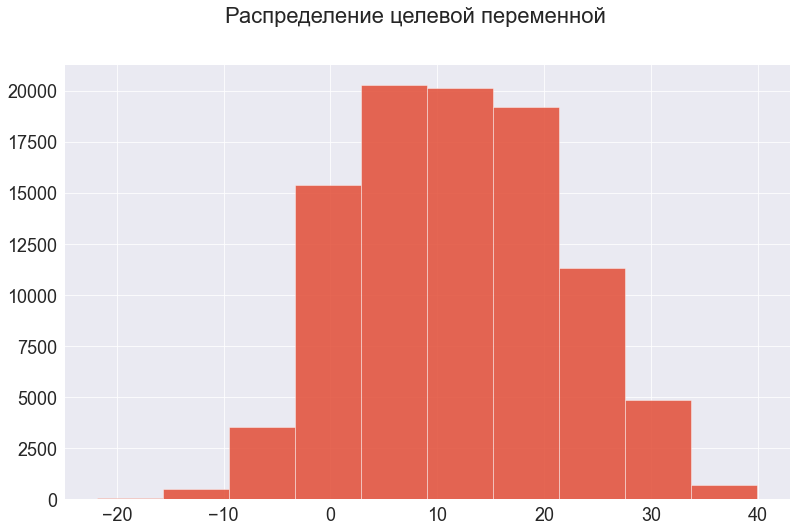

In [20]:

whh["Temperature (C)"].hist(figsize=(13,8), alpha=0.84)
plt.suptitle('Распределение целевой переменной', fontsize=22)
#Как видно по графику, распределение является нормальным


---

### Построение объясняющей модели

Теперь отберем несколько регрессоров, для построения модели:


Я строю модель:

$$
y_i = \beta_0 + \beta_1 Humidity + \beta_2 Precip Type_snow + \beta_3 Visibility (km) + \beta_4 Summary_Foggy + \beta_5 Summary_Partly Cloudy + \beta_6 Summary_Overcast + \varepsilon_i
$$

На выбор таких переменных повлияло построение корреляционной матрицы, и графиков рассеивания. 

Соответственно, были включены те переменные, которые имеют более сильную линейную связь с целевой переменной, такие переменные будут более полезны в **объясняющей** модели. (при это необходимо избегать ситуаций, когда одна переменная вляется линейной комбинацией другой переменной, иначе Мультиколлинеарность => Переобучение).

- Humidity - тк отрицательная линейная связь средней силы (-0.632148).
- Precip Type snow - тк отрицательная линейная связь средней силы (-0.563503).
- Visibility (km) - тк положительная линейная связь слабой силы (0.393719).
- Summary_Foggy - тк отрицательная линейная связь слабой силы (-0.310437).
- Summary_Partly Cloudy - тк положительная линейная связь слабой силы (0.300242).
- Summary_Overcast - тк отрицательная линейная связь слабой силы (-0.211532).



In [21]:
#Но для начала поменяю названия на более удобные мне:
whh = whh.rename(columns={'Visibility (km)': 'vis',
                          'Precip Type_snow': 'snow',
                          'Humidity': 'hum',
                          'Summary_Foggy': 'fog',
                          'Summary_Partly Cloudy': 'clo',
                          'Summary_Overcast': 'over',
                          'Wind Bearing (degrees)': 'wbear',
                          'Wind Speed (km/h)': 'wspeed',
                          'Pressure (millibars)': 'press'})

X = X.rename(columns={'Visibility (km)': 'vis',
                          'Precip Type_snow': 'snow',
                          'Humidity': 'hum',
                          'Summary_Foggy': 'fog',
                          'Summary_Partly Cloudy': 'clo',
                          'Summary_Overcast': 'over',
                          'Wind Bearing (degrees)': 'wbear',
                          'Wind Speed (km/h)': 'wspeed',
                          'Pressure (millibars)': 'press'})

Выделим выбранные признаки в переменную `X1`. 

In [22]:

X1 = whh[['hum', 'snow', 'vis', 'fog', 'clo', 'over']]



Оценим модель при помощи МНК (минимзации MSE).

In [23]:

l = LinearRegression()
l.fit(X1, Y)

print(l.intercept_) #Коэффициент при константе (т.е. если все регрессоры равны нулю, то температура 28.87 С)
print(l.coef_) #Коэффициенты при регрессорах (показывают силу и характер влияния на целевую переменную)
print(l.score(X1, Y)) #R квадрат ("объясняемость" целевой переменной через выбранные регрессоры)


28.8724750711497
[-23.52228902 -12.79845042   0.14152969   0.07238161   1.43737034
  -0.96519495]
0.5939926051145097


In [25]:

ypred = l.predict(X1) #Построим предсказание
sk.metrics.mean_squared_error(Y, ypred) #MSE(используется для сравнения регрессионых моделей,чем меньше,тем лучше)



37.157601959044236

In [26]:
#Проделаем то же самое, но через пакет статсмоделса:


l1 = smf.ols(formula='Y ~ hum +  snow + vis + clo + fog + over', data=whh).fit() 
#l1.params
l1.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                 2.337e+04
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        20:07:02   Log-Likelihood:            -3.0931e+05
No. Observations:               95864   AIC:                         6.186e+05
Df Residuals:                   95857   BIC:                         6.187e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.8725      0.121    239.254      0.000      28.636      29.109
hum          -23.5223      0.115   -204.520      0.000     -23.748     -23.297
snow         -12.7985      0.067   -191.300      0.000     -12.930     -12.667
vis            0.1415      0.006     22.624      0.000       0.129       0.154
clo            1.4374      0.047     30.895      0.000       1.346       1.529
fog            0.0724      0.100      0.725      0.469      -0.123       0.268
over          -0.9652      0.059    -16.473      0.000      -1.080      -0.850
==============================================================================
Omnibus:                     1702.669   Durbin-Watson:                   0.128
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1462.524
Skew:                          -0.243   Prob(JB):                         0.00
Kurtosis:                       2.639   Cond. No.                         90.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Коэффициенты были получены двумя сопосбами. Пояснения уже написаны.

Самое важное, что еще не было сказано, так это то, что все коэффициенты, кроме 'fog'(туманность) при регрессорах являются Значимыми, тк. P>|t| везде меньше, чем 0.05. Это значит, что в следующем задании уместно рассматривать их влияние на целевую переменную.



Поясним как каждый регрессор влияет на целевую переменную:



1.
- При увеличении Влажности на 1(г/м3),Температура уменьшается на ~23.5 градусов; 
- При увеличении Видимости на 1(км), Температура увеличивается на 0.14 градусов;
- В ситуациях когда идет снег, Температура уменьшается на ~12.8 градусов, чем когда снега нет;
- В ситуациях когда Облачность, Температура увеличивается на 1.4 градуса
- В ситуациях когда Туманно, Температура увеличивается на 0.07 градусов
- В ситуациях когда Пасмурно, Температура увеличивается на 1.4 градуса


2.
- Влажность влияет на Температуру отрицательно, потому что влажность воздуха и его температура впрнцп обратно пропорциональны, могу предположить следующее: увеличение температуры влечет за собой увеличение кинетической энергии молекул, находящихся в воздухе, следовательно, при увеличении кин. энергии, молекулы начинают увеличивать свою скорость и тем самым повышают испаряемость воздуха, а испаряемость в свою очередь обратнопропорционально связана с относительной влажностью, т.е. чем выше температура, тем выше испаряемость, чем выше испаряемость, тем меньше влажность;

- Видимость влияет на Температуру положительно, скорее всего, тут связь происходит через туманность;

- Ситуации, когда идет снег, температура ниже, это весьма логично;

- Ситуации, когда есть туман, температура выше, туманы могут быть вызваны изменениями в температуре или изменении влажности воздуха, то есть влияние может происходить в обе стороны (температура может быть как выше, так и ниже), поэтому по имеющимся данным, влияние измеряется как +0.07 градусов;
 
- Наличие облаков влияют на Температуру положительно, что немного странно(потому что облака задерживают прохождение тепловой энергии;

- Ситуации, когда Пасмурно, то Температура, как правило, выше, сложно однозначно объяснить почему, возможно, это связано с давлением воздуха;


Рассчитаем $R^2$ и MSE на выборке `X1`. И оценим качество регрессионной модели:

In [27]:

print(l.score(X1, Y))

#~59% => Среднее качество подгонки регрессии, 
# т.е. целевая переменная через регрессоры может быть объяснена только на 59%.


0.5939926051145097


In [28]:
ypred = l.predict(X1)
sk.metrics.mean_squared_error(Y, ypred)

#Довольно низкая оценка, что хорошо, но пока что это не о чем особо не говорит, 
#MSE нужно использовать для сравнения моделей

37.157601959044236

---

### Построение предсказательной модели

В предыдущей части мы хотели объяснить $y$ при помощи каких-то регрессоров, которые мы отбирали из теоретико-логических соображений. Теперь поставим другую задачу: мы не хотим ничего объяснять, а хотим только хорошо предсказывать $y$ по новым наблюдениям. Код ниже поделит выборку (`X`, `y`) на обучающую (`X_train`, `y_train`), на которой будем *оценивать* модель, и *тестовую* (`X_test`, `y_test`), на которой будем предсказывать. 

In [29]:

from sklearn.model_selection import train_test_split


In [30]:
#Предсказание на тестовой

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, Y, test_size = 0.3)#возьмем размерность 30% к 70%
ll1 = LinearRegression()
ll1.fit(X_test_1, y_test_1)
y_pred1 = ll1.predict(X_test_1) #Предсказываем

sk.metrics.mean_absolute_error(y_test_1, y_pred1) #МАЕ



5.000599461112269

In [31]:

r2_score(y_test_1, ll1.predict(X_test_1))
#коэф детерминации равен 59%


0.5971237018665905

In [32]:
#Предсказание на тренировочной

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, Y, test_size = 0.3)
lm1 = LinearRegression()
lm1.fit(X_train_1, y_train_1)
y_predt1 = lm1.predict(X_train_1)

sk.metrics.mean_absolute_error(y_train_1, y_predt1)


5.016922311696919

In [33]:

r2_score(y_train_1, lm1.predict(X_train_1))
#коэф детерминации равен 59%


0.5935636360874781

На тренировочной и тестовой получаем примерно одинаковые показатели, следовательно, данные однородны и ситуации "переобучения" не возникло.

---

Попробуем, ради эксперимента, к имеющимся выборкам добавить какие-нибудь доп. признаки.

In [34]:
X.columns.tolist()

['Summary',
 'Precip Type',
 'hum',
 'wspeed',
 'wbear',
 'vis',
 'press',
 'Summary_Breezy and Dry',
 'Summary_Breezy and Foggy',
 'Summary_Breezy and Mostly Cloudy',
 'Summary_Breezy and Overcast',
 'Summary_Breezy and Partly Cloudy',
 'Summary_Clear',
 'Summary_Dangerously Windy and Partly Cloudy',
 'Summary_Drizzle',
 'Summary_Dry',
 'Summary_Dry and Mostly Cloudy',
 'Summary_Dry and Partly Cloudy',
 'fog',
 'Summary_Humid and Mostly Cloudy',
 'Summary_Humid and Overcast',
 'Summary_Humid and Partly Cloudy',
 'Summary_Light Rain',
 'Summary_Mostly Cloudy',
 'over',
 'clo',
 'Summary_Rain',
 'Summary_Windy',
 'Summary_Windy and Dry',
 'Summary_Windy and Foggy',
 'Summary_Windy and Mostly Cloudy',
 'Summary_Windy and Overcast',
 'Summary_Windy and Partly Cloudy',
 'snow']

In [35]:
#Предсказание на тестовой

#Добавим три переменные (wbear, Pressure, Wind speed)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X[['hum', 'snow', 'vis', 'fog', 'clo', 'over', 'wbear', 'wspeed', 'press']],\
                                                            Y, test_size = 0.3)

ll2 = LinearRegression()
ll2.fit(X_test_2, y_test_2)
y_pred2 = ll2.predict(X_test_2)

sk.metrics.mean_absolute_error(y_test_2, y_pred2)



4.873555442299893

In [36]:
#Предсказание на тренировочной

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X[['hum', 'snow', 'vis', 'fog', 'clo', 'over', 'wbear', 'wspeed', 'press']],\
                                                            Y, test_size = 0.3)

ll2 = LinearRegression()
ll2.fit(X_train_2, y_train_2)
y_predt2 = ll2.predict(X_train_2)

sk.metrics.mean_absolute_error(y_train_2, y_predt2)


4.886811658486724

In [185]:
#Оцените модель на выборке X_train_2

r2_score(y_train_2, ll2.predict(X_train_2))



0.6115642047845957

<b>Новая модель предсказывает лучше, чем предыдущая: МАЕ меньше, а R^2 больше, что свидетельствует о повышении качества регрессионной модели.</b> 


---

Рассмотрим модель на Х2 подробнее:

In [186]:
print(ll2.coef_)

[-2.54359793e+01 -1.28132512e+01  1.40174044e-01 -2.54700798e-01
  1.04523448e+00 -6.16493334e-01  2.11842944e-03 -1.96081494e-01
 -8.35308378e-04]


In [189]:

ll2n = smf.ols(formula='Y ~ hum +  snow + vis + clo + fog + over + wbear + wspeed + press', data=whh).fit()
ll2n.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                 1.680e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:53:47   Log-Likelihood:            -3.0713e+05
No. Observations:               95864   AIC:                         6.143e+05
Df Residuals:                   95854   BIC:                         6.144e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.0183      0.206    160.116      0.000      32.614      33.422
hum          -25.3590      0.116   -218.914      0.000     -25.586     -25.132
snow         -12.8055      0.065   -195.683      0.000     -12.934     -12.677
vis            0.1420      0.006     23.123      0.000       0.130       0.154
clo            1.0507      0.046     22.854      0.000       0.961       1.141
fog           -0.2864      0.098     -2.920      0.003      -0.479      -0.094
over          -0.6222      0.058    -10.809      0.000      -0.735      -0.509
wbear          0.0020      0.000     11.079      0.000       0.002       0.002
wspeed        -0.1952      0.003    -66.555      0.000      -0.201      -0.189
press         -0.0010      0.000     -5.848      0.000      -0.001      -0.001
==============================================================================
Omnibus:                     1320.490   Durbin-Watson:                   0.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1295.966
Skew:                          -0.261   Prob(JB):                    3.84e-282
Kurtosis:                       2.770   Cond. No.                     1.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b>Стоит заметить, что теперь все коэффициенты стали значимыми.</b>

<b>Интересно, что удалось добиться такого улучшения, учитывая, что дополнительные признаки не выбирались с т.з. какого-то логического умозаключения или анализа, но все равно положительно повлияли на модель.</b>

---